[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guilbera/colorizing/blob/main/notebooks/pytorch_implementation/pix_pytorch.ipynb)

In [ ]:
import os
import torch
from PIL import Image
from skimage.transform import resize
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
if 'google.colab' in str(get_ipython()):
  !pip install kora -q
  from kora import drive
  drive.link_nbs()

     |████████████████████████████████| 61kB 2.5MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
Mounted at /content/drive


In [ ]:
from pix import rgb_to_lab

importing Jupyter notebook from /nbs/pix.ipynb


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, paths, im_size=256, crop_size=224, split='train'):
        self.split = split
        self.paths = paths
        self.total_imgs = os.listdir(paths)

        #for the train set, data augmentation with RandomHorizontalFlip
        if self.split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((im_size, im_size)),
                transforms.RandomHorizontalFlip(), 
            ])
        #for the test set, make sure that the image are at the right size only
        elif self.split == 'test':
            self.transforms = transforms.Resize((im_size, im_size))
        
        #this preprocessing is for the input of the classifier for the gamma model
        #it is not used for the other models
        self.preprocess = transforms.Compose([
            transforms.Resize(im_size),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            ])

  def __len__(self):
        return len(self.total_imgs)

  def __getitem__(self, index):
        #open the image in RGB
        img_loc = os.path.join(self.paths, self.total_imgs[index])
        img = Image.open(img_loc).convert('RGB')

        #preprocess the images for the classifier (gamma model)
        input_tensor = self.preprocess(img)

        #augment the images and transform them to LAB
        img_input = self.transforms(img)
        img_lab = rgb_to_lab(img_input)

        #return L, ab and embed separately
        return {'L': transforms.ToTensor()(img_lab['L']), 'ab': transforms.ToTensor()(img_lab['ab'])} , input_tensor

In [ ]:
def make_dataloaders(batch_size=16, im_size=256, split='Train', n_workers=2, pin_memory=True, shuffle=True, **kwargs):
    dataset = ImageDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

### **Example on how to use the generator**

In [ ]:
run_example = False

Cloning into 'colorizing'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 143 (delta 57), reused 97 (delta 22), pack-reused 0
Receiving objects: 100% (143/143), 20.32 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (57/57), done.


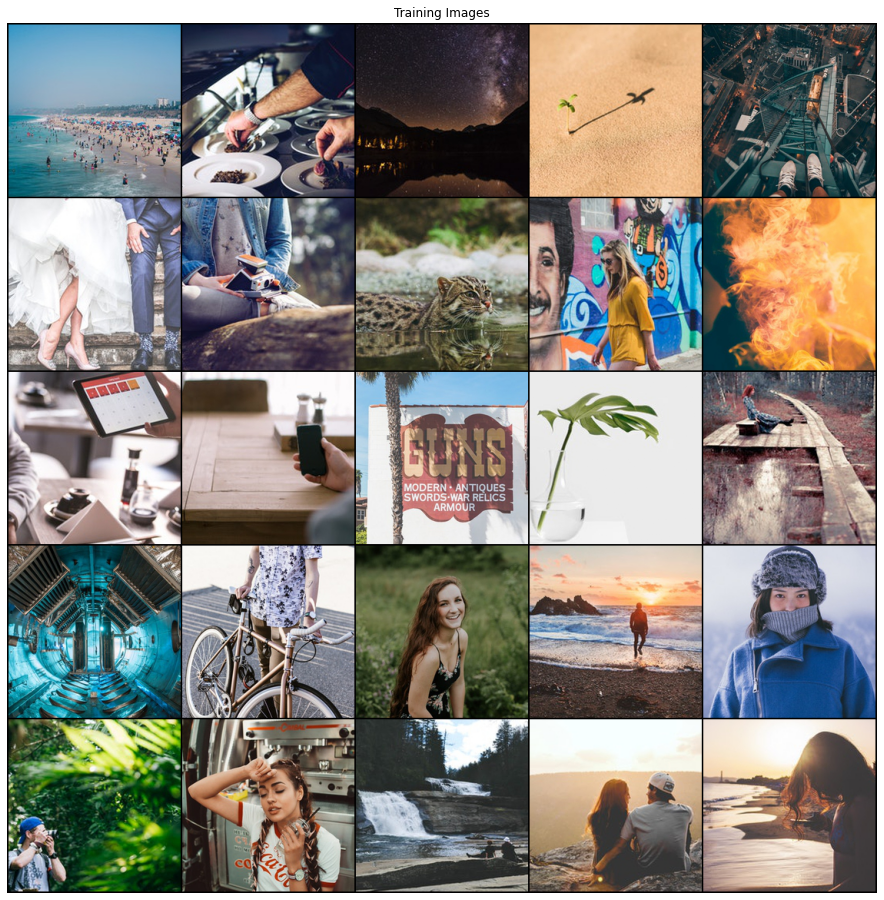

In [ ]:
if 'google.colab' in str(get_ipython()) and run_example:
  import os
  import torch
  import matplotlib.pyplot as plt
  import torchvision.utils as vutils
  import numpy as np
  from shutil import copy

  #copy the relevant notebooks
  !git clone https://github.com/guilbera/colorizing.git
  copy(os.path.join('/content/colorizing/notebooks/utilities/pix.ipynb'), '/content/drive/MyDrive/Colab Notebooks/')
  for nbs in os.listdir('/content/colorizing/notebooks/pytorch_implementation/'):
    copy(os.path.join('/content/colorizing/notebooks/pytorch_implementation/', nbs), '/content/drive/MyDrive/Colab Notebooks/')

  from pix import copy_dataset, rgb_to_lab

  #copy the dataset to google drive
  if not os.path.exists('/content/drive/MyDrive/datasets/'):
    !mkdir '/content/drive/MyDrive/datasets/'
    %cd '/content/drive/My Drive/datasets/'
    !gdown --id '1hNXR_qPwNKS-z3xNQJ4fWlEWe-zES_nX'
    %cd '/content/'

  copy_dataset('/content/drive/MyDrive/datasets/dataset_1.zip')
  generator = make_dataloaders(batch_size=25, im_size=256, split = 'Train', paths='/content/dataset/dataset_1/Train/', n_workers=1)
  color_grid = vutils.make_grid(next(iter(generator))[1], padding=2, normalize=True, nrow=5).cpu()
  
  plt.figure(figsize=(16,16))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(color_grid,(1,2,0)))